In [239]:
from pathlib import Path

import awkward as ak
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm

In [240]:
def summary_to_df(rootobj, keys):
    return ak.to_dataframe(rootobj.arrays(keys), how='outer').reset_index().drop(columns=["entry","subentry", "subsubentry"])

In [241]:
inputDir = Path("../output_telescope_geant4_100events")
summary_gsf_root = uproot.open(str(inputDir / "root/tracksummary_gsf.root:tracksummary"))
summary_kf_root = uproot.open(str(inputDir / "root/tracksummary_kf.root:tracksummary"))

In [242]:
keys = [ k for k in summary_gsf_root.keys() if not k in ['measurementChi2', 'outlierChi2', 'measurementVolume', 'measurementLayer', 'outlierVolume'] ]
print(keys)

['event_nr', 'multiTraj_nr', 'subTraj_nr', 'nStates', 'nMeasurements', 'nOutliers', 'nHoles', 'nSharedHits', 'chi2Sum', 'NDF', 'outlierLayer', 'nMajorityHits', 'majorityParticleId', 't_charge', 't_time', 't_vx', 't_vy', 't_vz', 't_px', 't_py', 't_pz', 't_theta', 't_phi', 't_eta', 't_p', 't_pT', 't_d0', 't_z0', 'hasFittedParams', 'eLOC0_fit', 'eLOC1_fit', 'ePHI_fit', 'eTHETA_fit', 'eQOP_fit', 'eT_fit', 'err_eLOC0_fit', 'err_eLOC1_fit', 'err_ePHI_fit', 'err_eTHETA_fit', 'err_eQOP_fit', 'err_eT_fit', 'res_eLOC0_fit', 'res_eLOC1_fit', 'res_ePHI_fit', 'res_eTHETA_fit', 'res_eQOP_fit', 'res_eT_fit', 'pull_eLOC0_fit', 'pull_eLOC1_fit', 'pull_ePHI_fit', 'pull_eTHETA_fit', 'pull_eQOP_fit', 'pull_eT_fit']


In [243]:
summary_gsf = summary_to_df(summary_gsf_root, keys)
summary_kf = summary_to_df(summary_kf_root, keys)

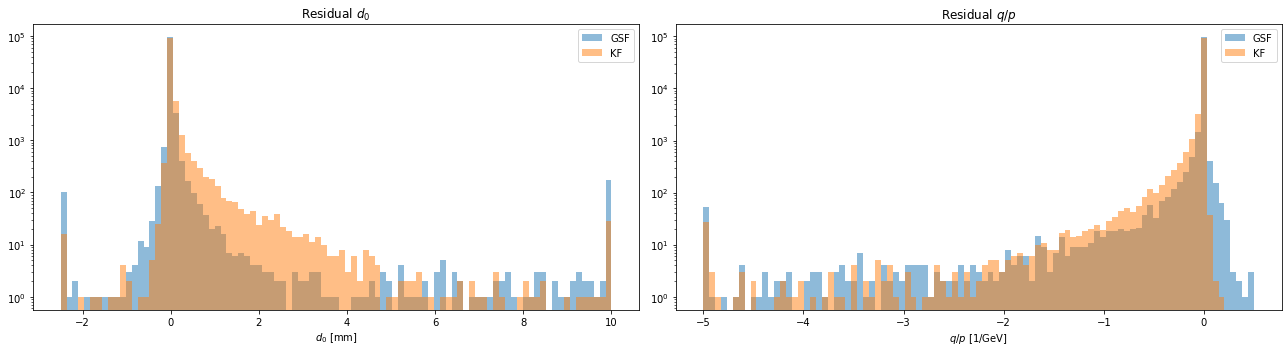

In [253]:
fig, axes = plt.subplots(1,2, figsize=(18,5))

for ax, key, clip, coor, unit in zip(axes, ["res_eLOC0_fit", "res_eQOP_fit"], [(-2.5,10), (-5.,.5)], ["$d_0$", "$q/p$"], ["mm", "1/GeV"]):
    bins="rice"
    
    for df, fitter in zip([summary_gsf, summary_kf], ["GSF", "KF"]):
        _, bins, _ = ax.hist(np.clip(df[key], *clip), bins=bins, label=fitter, alpha = 0.5)
        ax.set_title("Residual {}".format(coor))
        ax.legend()
        ax.set_yscale('log')
        ax.set_xlabel("{} [{}]".format(coor, unit))
        
fig.tight_layout()

## Core-Tail resolution

In [257]:
def analyse_core_tail(df, n_rms=3):
    hist_qop, bins_qop = np.histogram(np.clip(df["res_eQOP_fit"],-2.0, 0.5), bins=300)
    argmax_qop = np.argmax(hist_qop)
    mode_qop = 0.5 * (bins_qop[argmax_qop] + bins_qop[argmax_qop+1])
    print("mode [q/p]", mode_qop)
    
    print("mean [q/p]", np.mean(df["res_eQOP_fit"]))
    
    print("std [q/p]", np.std(df["res_eQOP_fit"]))
    
    rms_qop = np.sqrt(np.mean(np.square(df["res_eQOP_fit"])))
    print("rms [q/p]", rms_qop)
    
    core_range = (mode_qop-n_rms*rms_qop, mode_qop+n_rms*rms_qop)
    print("core range", core_range)
    
    df["is_core"] = df["res_eQOP_fit"].between(*core_range)
    print("% core", 100. * sum(df["is_core"]) / len(df))
    
    core_part = df["res_eQOP_fit"][df["is_core"]]
    tail_part = df["res_eQOP_fit"][np.logical_not(df["is_core"])]

    fig, ax = plt.subplots(figsize=(20,5))

    fit_core = norm.fit(core_part)
    fit_tail = norm.fit(tail_part)
    
    #data_range = min(df["res_eQOP_fit"]), max(df["res_eQOP_fit"])
    data_range = -5, 0.5

    _, bins, _ = ax.hist(core_part, bins=100, label="core $\mu$={:.3f}, $\sigma$={:.3f}".format(*fit_core), range=data_range)
    _, bins, _ = ax.hist(tail_part, bins=bins, label="tail $\mu$={:.3f}, $\sigma$={:.3f}".format(*fit_tail), range=data_range)
    
    ax.set_yscale('log')
    ax.legend()
        
    return fig, ax

mode [q/p] 0.004166666883975267
mean [q/p] -0.021875657
std [q/p] 0.7247193455696106
rms [q/p] 0.7252776
core range (-2.8969437438063323, 2.905277077574283)
% core 99.87735858540165


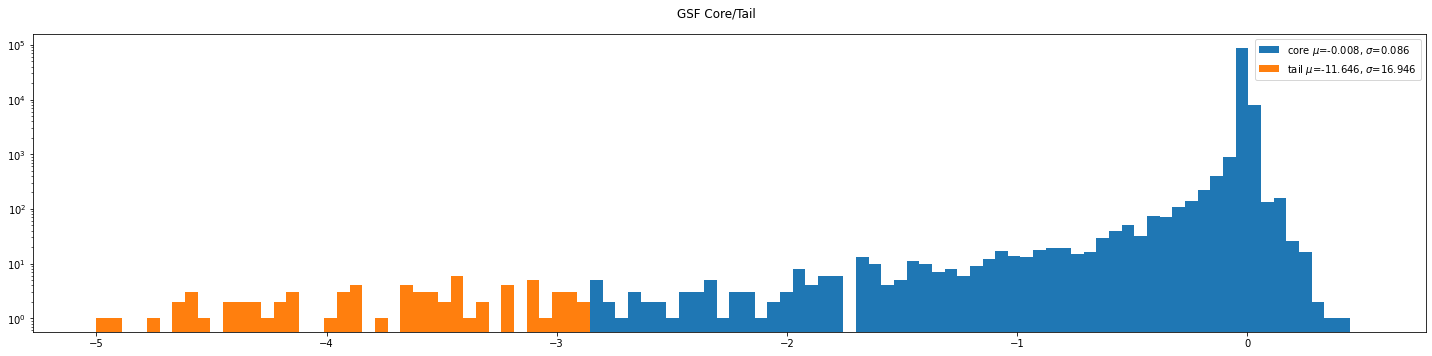

In [258]:
fig, ax = analyse_core_tail(summary_gsf, n_rms=4)
fig.suptitle("GSF Core/Tail")
fig.tight_layout()

mode [q/p] -0.0009495998965576291
mean [q/p] -0.0198621
std [q/p] 0.20286127924919128
rms [q/p] 0.20383362
core range (-0.8162840987788513, 0.8143848989857361)
% core 99.58285587921918


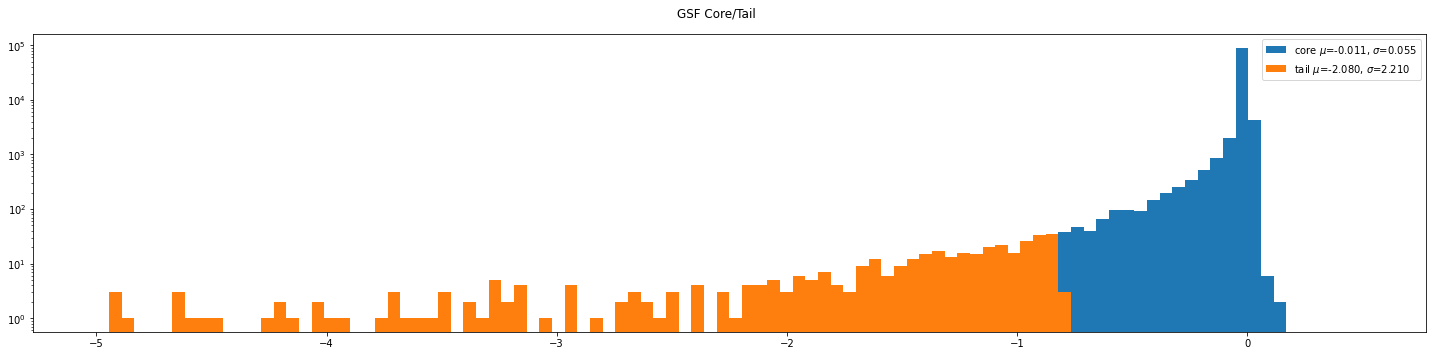

In [259]:
fig, ax = analyse_core_tail(summary_kf, n_rms=4)
fig.suptitle("GSF Core/Tail")
fig.tight_layout()